# Capstone Project : E-Commerce Customer Segmentation and Prediction
done by- Muthushree.A


---





**Problem:**

In this project, we analyze an extensive dataset of transactional behavior from online retail customers, including order frequency, purchase timing, and total spending. The goal is to uncover meaningful customer segments and build a predictive model capable of identifying high-value buyers—those who contribute disproportionately to business revenue. Given the importance of maximizing ROI through targeted marketing, the primary emphasis is on ensuring accurate detection of these profitable segments, making precision for the high-value class a critical performance metric.




### Objectives

1. **Understand the Data**  
   - Analyze customer behavior and spending trends  

2. **Conduct EDA**  
   - Visualize key RFM metrics and purchase patterns  

3. **Preprocess the Data**  
   - Clean missing values, outliers, and format features  

4. **Engineer Features**  
   - Build RFM scores and relevant aggregates  

5. **Segment Customers**  
   - Apply clustering models to identify segments  

6. **Build Predictive Models**  
   - Classify high-value customers using ML algorithms  

7. **Evaluate Performance**  
   - Compare models with precision, recall, and F1-score  

8. **Deploy & Visualize**  
   - Create a Gradio app and Power BI dashboard



---




## 1) Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

Imported all the necessary Libraries for this project


---



## 2) Data Preparation & Cleaning

### 2.1	Load & Inspect

- Imported raw CSV with InvoiceNo,	StockCode,	Description,	Quantity,	InvoiceDate,	UnitPrice,	CustomerID,	and Country.


In [ ]:
data = pd.read_csv('data/data (1).csv', encoding='latin1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- The 'data' Dataset has 8 columns and 541909 rows.

In [3]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 2.2) 'TotalPrice' - New column created
- A new column created in data set called 'TotalPrice' which is the product of 'Quantity' and 'UnitPrice' columns.
- Also (customer_total_amount) a new dataframe created which consists of ' CustomerID' and  'TotalPrice'.-

In [4]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

customer_total_amount = data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
customer_total_amount.rename(columns={'TotalPrice': 'TotalAmount'}, inplace=True)

display(customer_total_amount.head())

,CustomerID,TotalAmount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### 2.3) Finding and Handling Nulls And Neagtive Values
- Negative values spotted in 'Quantity', 'UnitPrice' and 'TotalPrice' columns.


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,17.987795
std,218.081158,96.759853,1713.600303,378.810824
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


- Spotted null values in 'Description' and 'CustomerID' columns.

In [6]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0
TotalPrice,0


- Dropped rows missing CustomerID.
- Filled missing ProductDescription with "Unknown".
- Filtered out records with Quantity ≤ 0 or TotalPrice ≤ 0.



In [7]:
# Drop rows with missing CustomerID
data.dropna(subset=['CustomerID'], inplace=True)

# Fill the missing values in Description with Unknown
data['Description'].fillna('Unknown')

# Remove rows with negative Quantity and UnitPrice
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0) & (data['TotalPrice'] > 0)]
# optional to put totalprice, coz if quantity and unit price are positive, then tp also will be obiviously positive.

display(data.describe())
display(data.isnull().sum())
data.shape

,Quantity,UnitPrice,CustomerID,TotalPrice
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453,22.397000
std,179.331775,22.097877,1713.141560,309.071041
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPrice,0


(397884, 9)

NOTE: Now the rows has been reduced to 397884 and columns increased to 9 after handling nulls and creating 'TotalPrice' column.

### 2.4) Data Type Corrections
- Cast 'CustomerID' and 'InvoiceNo' to string for consistency.
- Cast 'InvoiceDate' into datetime format

In [8]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object
TotalPrice,float64


In [9]:
#changing the data types for consistency

data['CustomerID'] = data['CustomerID'].astype(str)
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.4+ MB




---



## 3) Exploratory Data Analysis (EDA)

### 3.1)  Customer & Transaction Overview




- The Total number of Unique Customers is 4338 has been found

- The distribution is heavily skewed to the right, indicating that a large number of customers place a low number of orders.

- The majority of customers fall within the range of 1 to around 8 orders, as indicated by the peak and rapid decline in the histogram.

- There is a long tail extending to the right, representing a smaller number of customers who place a significantly higher number of orders. These are your most frequent buyers or highly loyal customers.

- The chart clearly shows that while you have a large base of customers who order infrequently, a smaller group contributes significantly through repeat purchases.


Total unique customers: 4,338


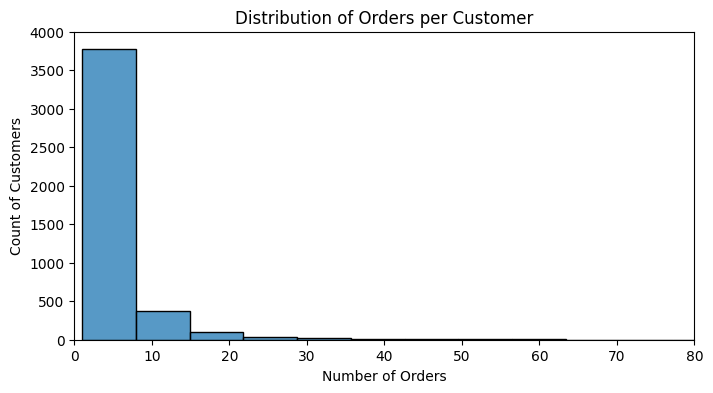

In [10]:
# Number of unique customers
n_customers = data['CustomerID'].nunique()
print(f"Total unique customers: {n_customers:,}")

# Orders per customer
orders_per_cust = data.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(8,4))
sns.histplot(orders_per_cust, bins=30, kde=False)
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Count of Customers")
plt.xlim(0, 80)
plt.ylim(0, 4000)
plt.show()

**Distribution of Total Spend per Customer:** Most of the customers price  ranges from 0-10,000 dollars. (Assumed that prices are in Dollars)

- The histogram is highly right-skewed. This indicates that a large majority of customers have relatively low total spending amounts.

- There is a long tail on the right side of the distribution, showing that a small number of customers have very high total spending amounts. These are your high-value customers in terms of monetary contribution.

- Most of the customer spending falls within the lower range, likely below a few thousand dollars, while the highest spenders are outliers in the distribution.

This distribution highlights the importance of identifying and potentially targeting the smaller group of high-spending customers.



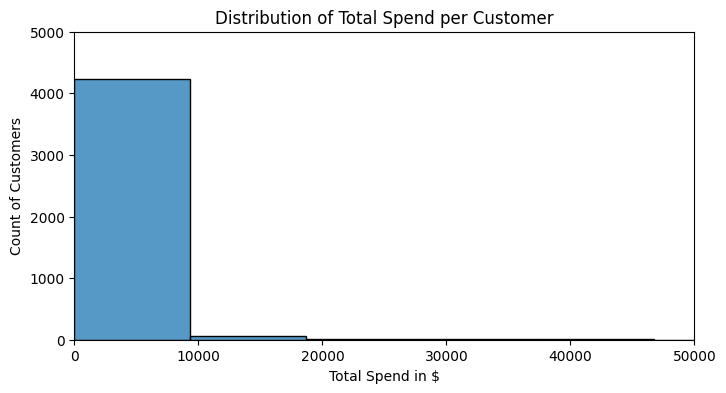

In [11]:
# Total spend per customer
spend_per_cust = data.groupby('CustomerID')['TotalPrice'].sum()
plt.figure(figsize=(8,4))
sns.histplot(spend_per_cust, bins=30, kde=False)
plt.title("Distribution of Total Spend per Customer")
plt.xlabel("Total Spend in $")
plt.ylabel("Count of Customers")
plt.xlim(0, 50000)
plt.ylim(0, 5000)
plt.show()

**Monthly Sales Trend:** Seasonal peaks in November–December (Line chart)

- The plot clearly shows the trend of total sales revenue over the months covered in the dataset.

- It can be observed that there is a seasonal patterns in sales. There appears to be a significant increase in sales towards the end of the year, particularly in November and December. This is a common pattern in retail due to holiday shopping.

- The plot helps identify months with high and low sales activity, which can inform staffing, inventory, and marketing decisions.

- Seeing the trend over time provides a valuable perspective on the overall business performance and growth (or decline) within the period of the dataset.

For example, the sharp peak in sales in November and December is a key takeaway from this chart.

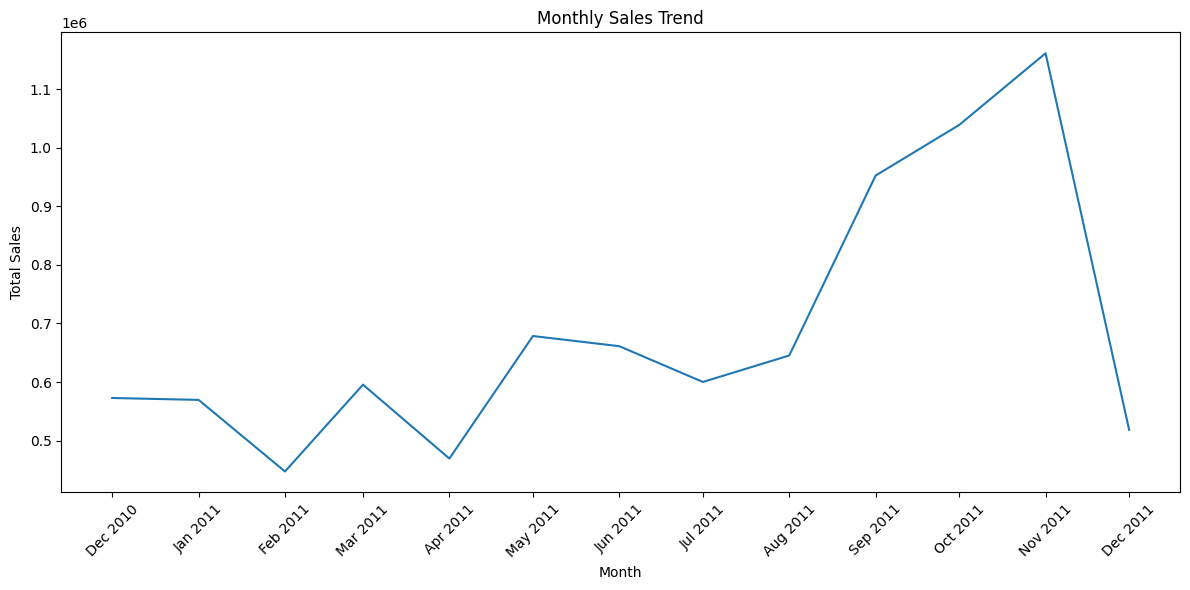

In [12]:
# Monthly Sales trend
# Extract month from InvoiceDate
data['Month'] = data['InvoiceDate'].dt.to_period('M')

# Calculate total monthly sales
monthly_sales = data.groupby('Month')['TotalPrice'].sum().reset_index()

# Convert month to datetime for sorting and plotting
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Sort by month
monthly_sales = monthly_sales.sort_values('Month')

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='TotalPrice')

# Format x-axis to display month names
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2) Product Insights




In [13]:
# Aggregate data by StockCode and Description
product_data = data.groupby(['StockCode', 'Description']).agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalPrice', 'sum')
).reset_index()


**Top 10 Products by Revenue using Bar chart:**

- The chart clearly highlights the products that are the biggest revenue generators. The length of each bar directly corresponds to the total revenue generated by that product.

- It can be easily identified the single product with the highest revenue by looking at the longest bar.

- The chart allows for a quick visual comparison of the revenue generated by the top products, showing the relative contribution of each to overall sales.

- Identifying these top revenue-generating products is crucial for inventory management, marketing strategies, and understanding customer demand for high-value items.

For example, the product "PAPER CRAFT , LITTLE BIRDIE" appears to be the top revenue earner by a significant margin in this dataset.

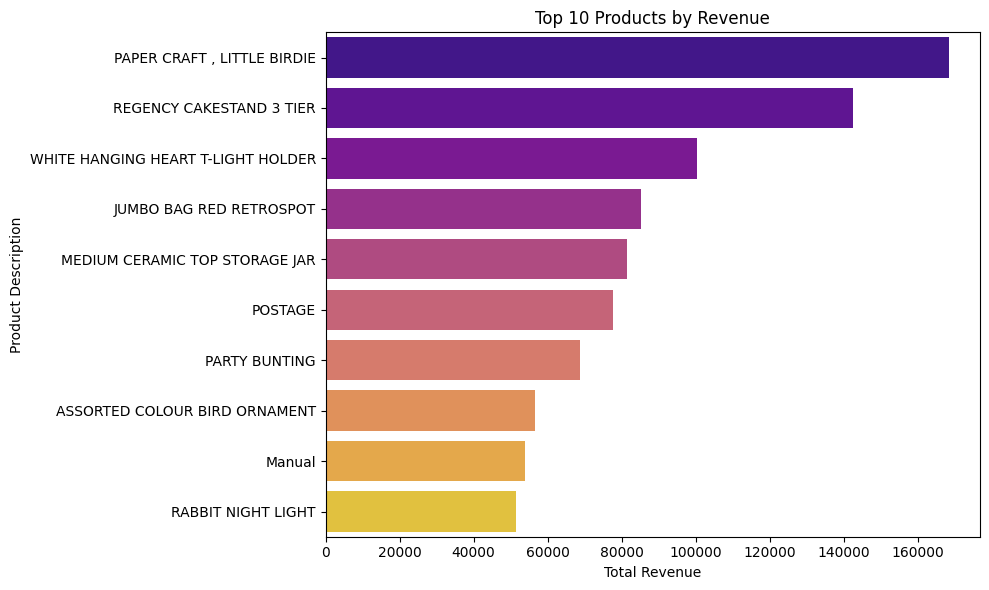

In [14]:
# Top 10 by Revenue
top_10_revenue = product_data.sort_values(by='TotalRevenue', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='TotalRevenue', y='Description', data=top_10_revenue, palette='plasma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

**Top 10 Products by Quantity Sold using Bar chart:**

- The chart identifies the products that are sold in the largest volumes. The length of each bar represents the total quantity sold for that product.

- It can be  easily seen which products are the most popular in terms of units moved.

- Comparing this chart to the "Top 10 Products by Revenue" chart can reveal interesting differences. Some products might sell in high quantities but have a lower unit price, resulting in lower revenue compared to products with lower quantity but higher unit price.

- Identifying these high-quantity products is important for inventory planning, logistics, and promotional strategies.

For instance, the product "PAPER CRAFT , LITTLE BIRDIE" also appears at the top of this list, indicating it's both a high-quantity and high-revenue product. Other products might be high in quantity but not in revenue, suggesting they are lower-priced items.

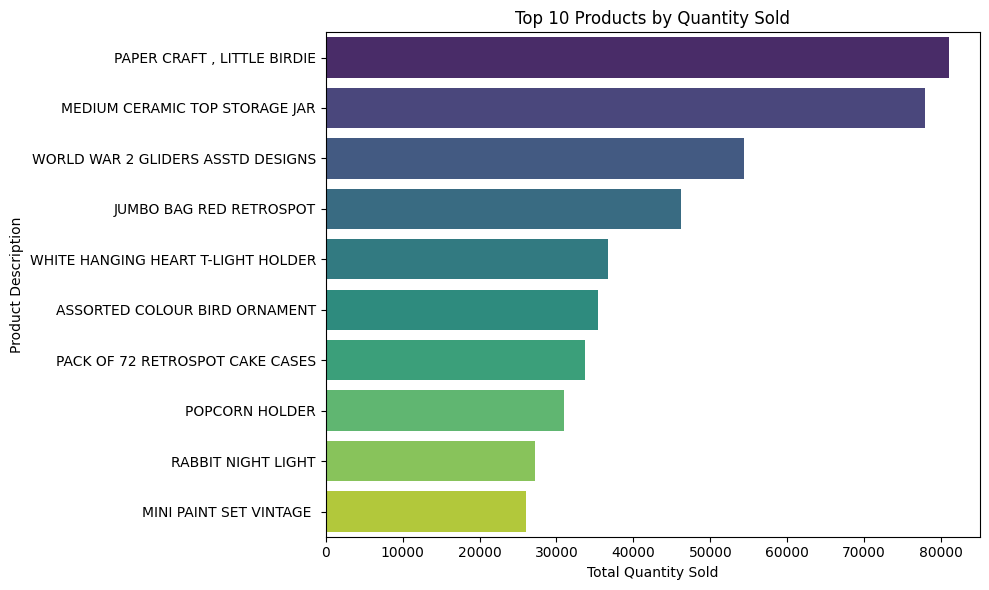

In [15]:
# Top 10 by Quantity
top_10_quantity = product_data.sort_values(by='TotalQuantity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='TotalQuantity', y='Description', data=top_10_quantity, palette='viridis')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()



---



## 4) RFM Feature Engineering
RFM (Recency, Frequency, Monetary) analysis is a powerful technique for segmenting customers based on behavior:
- Recency: how recently a customer made a purchase
- Frequency: how often they purchase
- Monetary: how much they spend
These features help tailor marketing strategies and personalize offerings.



In [16]:
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)


rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum' # Use the TotalPrice column and sum it
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary' # Rename TotalPrice to Monetary
})

### 4.1) RFM Distributions:
Distributions (Histograms):
- Recency: The distribution is right-skewed, with a
large number of customers having low Recency (purchased recently) and fewer customers having high Recency (haven't purchased in a while).

- Frequency: The distribution is also heavily right-skewed, indicating that most customers have a low purchase Frequency (buy infrequently), while a small number of customers buy very frequently.

- Monetary: This distribution is highly right-skewed as well, showing that the majority of customers have low Monetary values (spend small amounts), with a few high-spending customers.

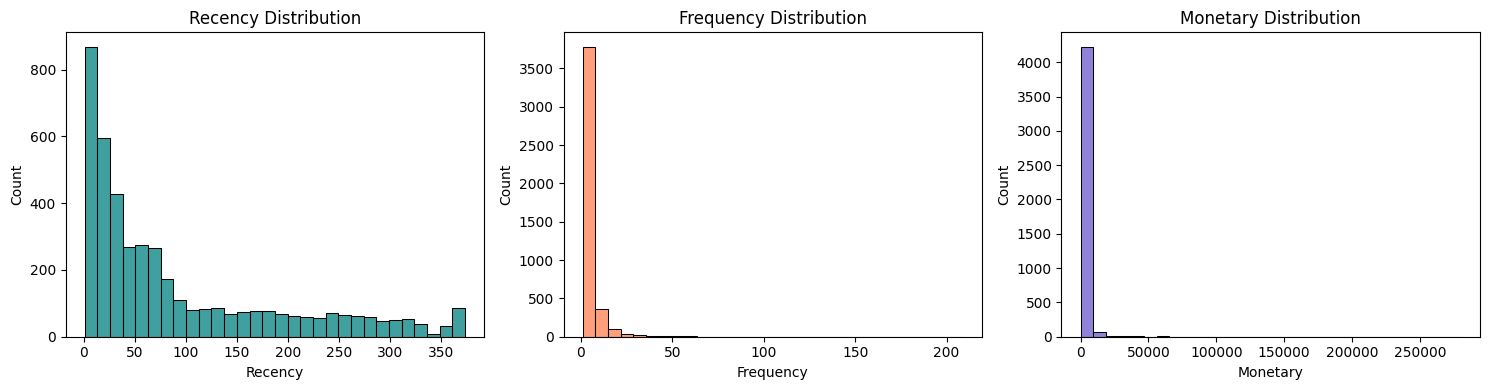

In [17]:
# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(rfm['Recency'], bins=30, ax=axes[0], color='teal')
axes[0].set_title("Recency Distribution")
sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], color='coral')
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], color='slateblue')
axes[2].set_title("Monetary Distribution")
plt.tight_layout()
plt.show()

### 4.2) RFM Relationships:
Relationships (Scatter Plots, Pairplot):

- There are positive correlations observed between Recency and Frequency, Recency and Monetary, and Frequency and Monetary. Customers who purchased recently tend to purchase more often and spend more. Customers who purchase more often also tend to spend more.

- The scatter plots and pairplot show that the relationships are not perfectly linear, and there are clusters or groups of customers with different combinations of RFM values. This visually supports the idea that customer segmentation is appropriate.

- The scatter plots also highlight the skewed nature of the data, with many points concentrated in the lower ranges of Frequency and Monetary values.

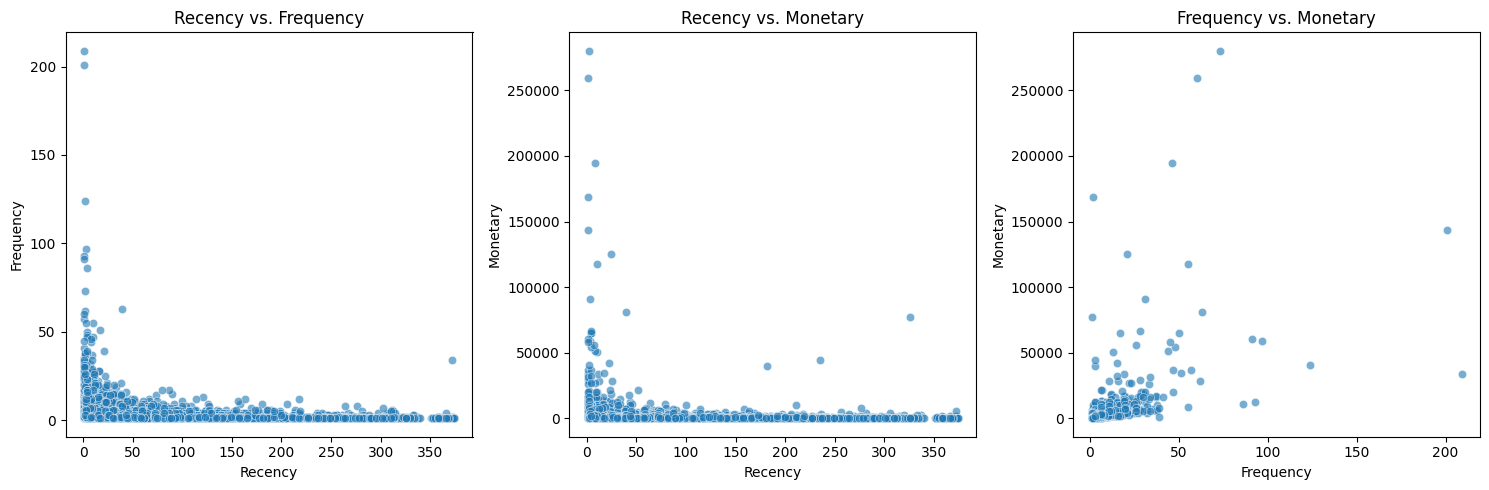

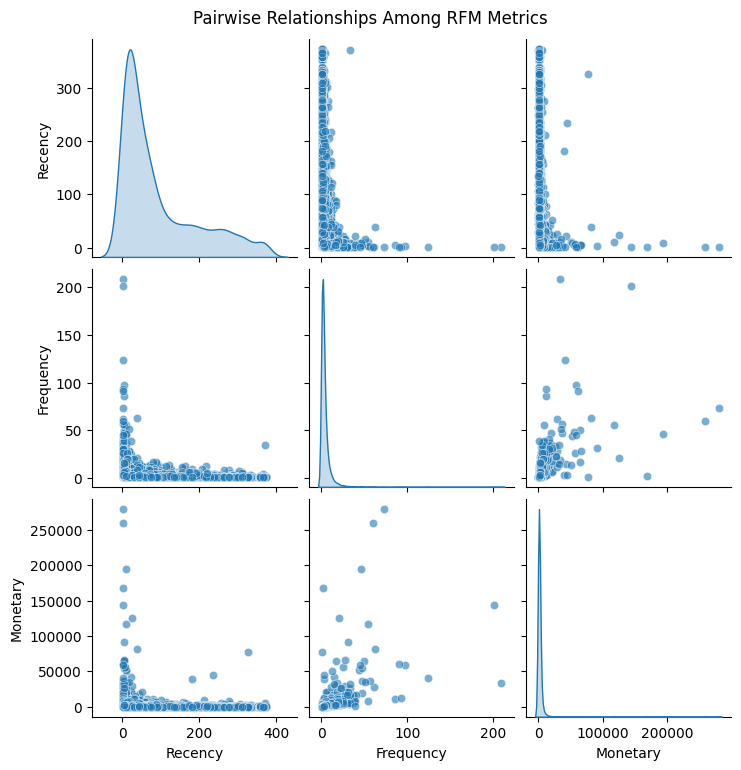

In [18]:
# Scatter plots of RFM pairs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', alpha=0.6)
plt.title('Recency vs. Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', alpha=0.6)
plt.title('Recency vs. Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', alpha=0.6)
plt.title('Frequency vs. Monetary')

plt.tight_layout()
plt.show()

# Pairplot for Recency, Frequency, Monetary
sns.pairplot(rfm, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Pairwise Relationships Among RFM Metrics", y=1.02)
plt.show()

### 4.3) RFM Correlations:
Correlations (Heatmap):
- The heatmap confirms the positive correlations between the RFM features.

- Frequency and Monetary values show a relatively stronger positive correlation compared to the correlations involving Recency. This indicates that how often a customer buys and how much they spend are more closely related to each other than they are to how recently the customer bought, although Recency still has a notable relationship with both.

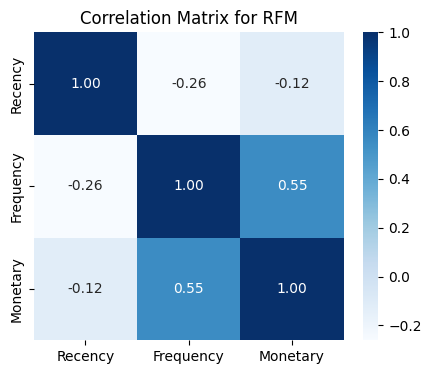

In [19]:
# Correlation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(rfm.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix for RFM")
plt.show()

In summary, the EDA reveals that your customer base is diverse in terms of their purchasing behavior, with a large group of customers who buy infrequently and spend little, and a smaller but significant group of more recent, frequent, and high-spending customers. The RFM metrics are positively correlated, providing a good basis for segmentation and predicting customer value.


---



## 5) Outlier Detection & Treatment
IQR Capping applied to each RFM feature:
- Values beyond Q3 + 1.5 × IQR capped to upper limit
- Values below Q1 – 1.5 × IQR floored to lower limit


In [20]:
# Function to detect outliers using IQR
def cap_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Capping: Replace values outside limits
    data[column] = np.where(data[column] > upper_limit, upper_limit,
                            np.where(data[column] < lower_limit, lower_limit, data[column]))
    return data

# Apply to each RFM feature
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm = cap_outliers_iqr(rfm, col)

Verified via post-capping boxplots: outliers reduced, distributions more uniform.

- Outlier capping successfully reduced extreme values in RFM distributions, making the data more suitable for clustering.

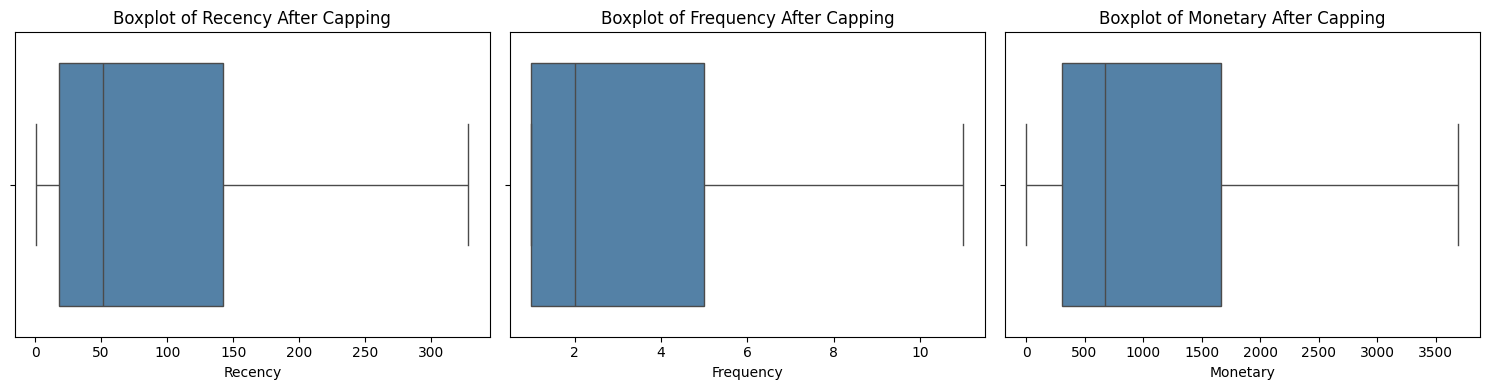

In [21]:
# Boxplots After Capping
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(x=rfm[col], ax=axs[i], color='steelblue')
    axs[i].set_title(f"Boxplot of {col} After Capping")
plt.tight_layout()
plt.show()



---



## 6) Feature Scaling

-	Standardized RFM with StandardScaler to zero mean and unit variance
- Prepared rfm_scaled matrix for distance-based clustering



In [22]:
#Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

rfm_scaled = pd.DataFrame(
    rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary']
)



---



## 7) Customer Segmentation
### 7.1) K-Means Clustering
Evaluating optimal k using silhouette score:
- The silhouette score is highest at K=3. Therefore best_k = 3 has been found.

- The silhouette score of the K-Means Clustering is (0.509).

- A higher silhouette score indicates better-defined and more separated clusters.

- This plot suggests that 3 is the optimal number of clusters for K-Means based on silhouette analysis.


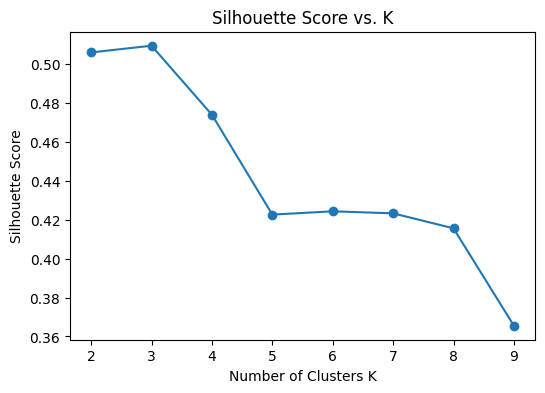

Best k: 3
KMeans Silhouette: 0.5095124208345764


In [23]:
sil_scores = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of Clusters K")
plt.ylabel("Silhouette Score")
plt.show()

# Choose best K
best_k = K_range[np.argmax(sil_scores)]
print("Best k:", best_k)

# Fit final model
km_final = KMeans(n_clusters=best_k, random_state=42)
rfm['KMeansSegment'] = km_final.fit_predict(rfm_scaled)
print("KMeans Silhouette:", silhouette_score(rfm_scaled, rfm['KMeansSegment']))

### 7.2) Hierarchical Clustering

- Performs Hierarchical Clustering on scaled RFM data.

- Visualizes clustering with a dendrogram.

- Assigns customers to 3 clusters (best_k).

- Calculates the Silhouette Score for the hierarchical segmentation (0.477)


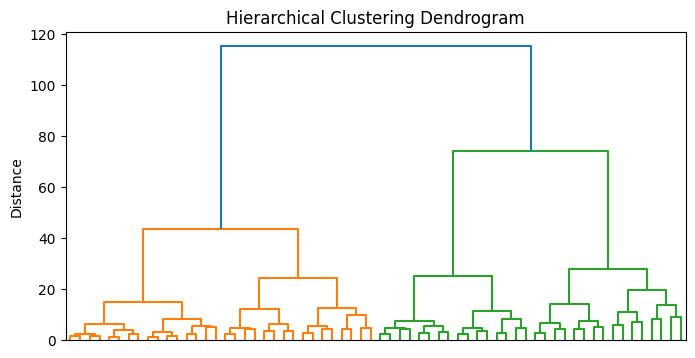

Hierarchical Silhouette: 0.4772355206325588


In [24]:
# Linkage matrix
link_mat = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(8, 4))
dendrogram(link_mat, no_labels=True, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Distance")
plt.show()

# Assign clusters
rfm['HierSegment'] = fcluster(link_mat, best_k, criterion='maxclust') - 1
print("Hierarchical Silhouette:", silhouette_score(rfm_scaled, rfm['HierSegment']))

### 7.3) DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

> Add blockquote


- Applies DBSCAN clustering to the scaled RFM data.

- Checks the number of clusters found, excluding noise points (labeled -1).

- With the current parameters (eps=0.8, min_samples=5), DBSCAN found only 1 cluster (excluding noise).

- Due to finding only one cluster, the silhouette score could not be calculated (requires at least 2 clusters).

- **Conclusion:** Based on these results, DBSCAN with the current parameters is not an optimal model for segmenting this data compared to K-Means, which successfully identified multiple distinct clusters. Further parameter tuning would be needed to see if DBSCAN could find more clusters.

In [25]:
# Run DBSCAN
db = DBSCAN(eps=0.8, min_samples=5)
rfm['DBSCANSegment'] = db.fit_predict(rfm_scaled)

# Check label count
labels = rfm['DBSCANSegment']
unique_labels = labels[labels != -1].nunique()

print("DBSCAN clusters (excluding noise):", unique_labels)

# Only compute silhouette if at least 2 clusters exist
if unique_labels >= 2:
    mask = labels != -1  # exclude noise
    score = silhouette_score(rfm_scaled[mask], labels[mask])
    print("DBSCAN Silhouette Score:", round(score, 3))
else:
    print("Not enough clusters for silhouette score (need ≥2 clusters).")

DBSCAN clusters (excluding noise): 1
Not enough clusters for silhouette score (need ≥2 clusters).


### 7.5 Algorithm Selection

*Selected: K-Means*

**K-Means Clustering:**
- Successfully identified 3 distinct customer clusters based on the silhouette score analysis
.
- Achieved a Silhouette Score of 0.509. A score above 0.5 generally indicates reasonably well-separated clusters.

**Hierarchical Clustering:**
- Also capable of identifying multiple clusters (you chose to cut the dendrogram to get 3).

- Achieved a Silhouette Score of 0.477. This is slightly lower than the K-Means score, suggesting the clusters might be slightly less well-defined or separated compared to K-Means.

**DBSCAN:**
- With the parameters used (eps=0.8, min_samples=5), it primarily identified noise points and only formed 1 significant cluster (excluding noise).

- The silhouette score could not be calculated as it requires at least two clusters.

- This indicates that DBSCAN, with these parameters, did not effectively segment your data into multiple meaningful groups.

**Conclusion:**

Considering the ability to form a reasonable number of distinct clusters and the silhouette scores, K-Means Clustering appears to be the optimal method among the three for segmenting your customers in this case. It provided the highest silhouette score and successfully identified multiple clusters that are reasonably well-separated.

### **Optimal Algorithm : K-Means Clustering**
### Elbow Method: SSE vs. Number of Clusters:
- The plot shows the sum of squared distances (Inertia) for different values of K (number of clusters).

- The SSE decreases as the number of clusters increases, as expected (more clusters can better fit the data).

- The "elbow point" in the plot is where the rate of decrease in SSE changes significantly.

- In this plot, there is a visible elbow around k=3. This is where adding more clusters starts to yield diminishing returns in terms of reducing the within-cluster sum of squares.

- The elbow method suggests that k=3 is a reasonable number of clusters for your data.

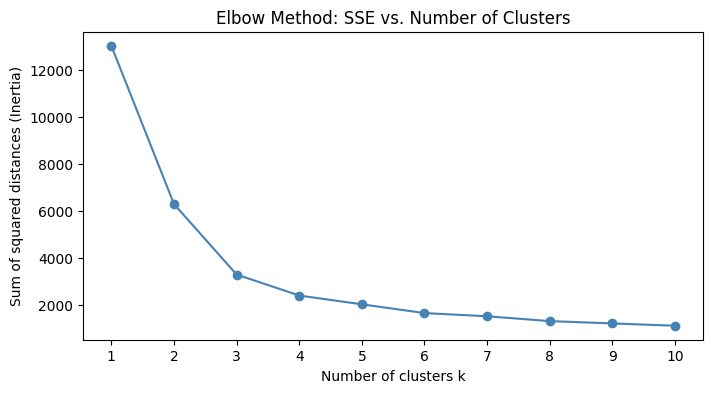

In [26]:
# Compute sum of squared distances for k = 1-10
sse = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)  # inertia_ = sum of squared distances to centroids

# Plot the elbow
plt.figure(figsize=(8,4))
plt.plot(K_range, sse, 'o-', color='steelblue')
plt.title("Elbow Method: SSE vs. Number of Clusters")
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distances (Inertia)")
plt.xticks(K_range)
plt.show()

This code fits the final K-Means model with the chosen best_k (which is 3) to your scaled RFM data and assigns a segment label (0, 1, or 2) to each customer in the rfm DataFrame.

The counts for each of these segments are:

- Segment 0: 2327 customers
- Segment 1: 962 customers
- Segment 2: 1049 customers

out of total number of unique customers which is 4338.

In [27]:
# Choose k based on elbow
best_k = 3

kmeans_final = KMeans(n_clusters=best_k, random_state=42)
rfm['KMeansSegment'] = kmeans_final.fit_predict(rfm_scaled)

# View segment counts
print(rfm['KMeansSegment'].value_counts().sort_index())

KMeansSegment
0    2327
1     962
2    1049
Name: count, dtype: int64


In essence, this code provides a quantitative measure of how well-defined and separated the clusters are.

- A silhouette score closer to 1 indicates well-separated clusters, a score near 0 indicates overlapping clusters, and a score near -1 indicates that data points might have been assigned to the wrong clusters.

- This code calculates and prints the Silhouette Score (0.510) for the K-Means clustering with k=3, indicating reasonably well-separated clusters.



In [28]:
# Calculation of sillhouette score
score = silhouette_score(rfm_scaled, rfm['KMeansSegment'])
print(f"Silhouette Score for k={best_k}: {score:.3f}")

Silhouette Score for k=3: 0.510


Based on the analysis of their centroids (the average Recency, Frequency, and Monetary values for each group), the three K-Means segments indicate the following types of customer behavior:

- Segment 0 (Moderate/Recent Buyers): These customers purchased relatively recently but do not order very frequently and have a moderate total spending amount.

- Segment 1 (High-Value/Loyal Customers): These are your most active and valuable customers. They have purchased recently, do so frequently, and have the highest total spending amount.

- Segment 2 (Lapsed/Low-Value Customers): These customers have not purchased in a long time, order infrequently, and have the lowest total spending amount.

These segments categorize your customers into distinct groups based on their purchasing habits, which can be very useful for tailoring marketing efforts and business strategies.


In [29]:
# Centroids in scaled space → transform back to original RFM
centroids_scaled = kmeans_final.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids, columns=['Recency', 'Frequency', 'Monetary'])
print(centroid_df)

      Recency  Frequency     Monetary
0   48.954038   2.465206   732.739713
1   26.810417   8.167708  3010.622440
2  244.758095   1.471429   427.331849


**Visualize Centroids on Scatter Plots**

- The red 'X' markers clearly show the average location (centroid) of each of the three customer segments in the RFM space.

- The centroids are positioned near the center of the clusters of data points that were assigned to each respective segment (colored by KMeansSegment).

- The plot helps visually confirm that the K-Means algorithm found distinct centers for groups of customers with similar RFM characteristics.

- Specifically, you can see how the centroid for Segment 1 (High-Value) is located towards lower Recency, higher Frequency, and higher Monetary values compared to the other segments.

- The centroid for Segment 2 (Lapsed/Low-Value) is positioned towards higher Recency, lower Frequency, and lower Monetary values.

- The centroid for Segment 0 (Moderate/Recent) is in an intermediate position.

- Here we can also see that recency and monetary are taken as continous data but frequency as a discrete data.

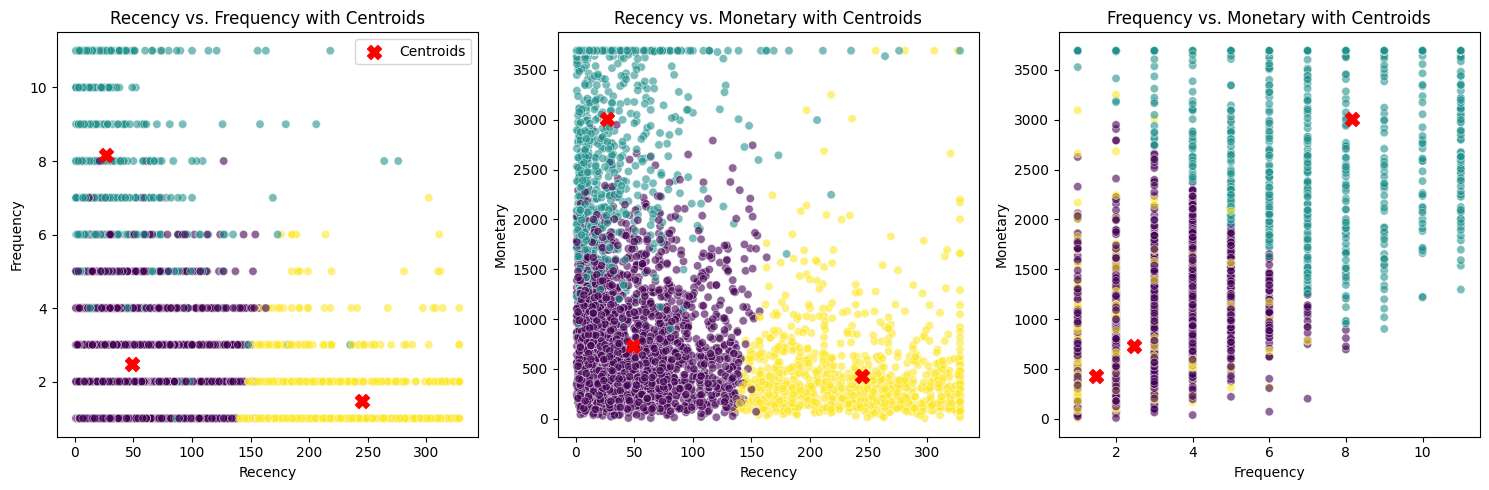

In [30]:
# Visualize centroids on scatter plots
plt.figure(figsize=(15, 5))

# Recency vs. Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='KMeansSegment', palette='viridis', alpha=0.6, legend=False)
plt.scatter(centroid_df['Recency'], centroid_df['Frequency'], c='red', s=100, marker='X', label='Centroids')
plt.title('Recency vs. Frequency with Centroids')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

# Recency vs. Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='KMeansSegment', palette='viridis', alpha=0.6, legend=False)
plt.scatter(centroid_df['Recency'], centroid_df['Monetary'], c='red', s=100, marker='X', label='Centroids')
plt.title('Recency vs. Monetary with Centroids')
plt.xlabel('Recency')
plt.ylabel('Monetary')

# Frequency vs. Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='KMeansSegment', palette='viridis', alpha=0.6, legend=False)
plt.scatter(centroid_df['Frequency'], centroid_df['Monetary'], c='red', s=100, marker='X', label='Centroids')
plt.title('Frequency vs. Monetary with Centroids')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

plt.tight_layout()
plt.show()



---



## 8) Predictive Classification


In [31]:
# define 'HighValue' label based on K-Means Segmentation
# Assuming Segment 1 was identified as the 'High-Value/Loyal Customers' segment
# based on the centroid analysis (checks centroid analysis to confirm the segment number)
high_value_segment_number = 1

# Create the 'HighValue' label: 1 if in the high-value segment, 0 otherwise
rfm['HighValue'] = (rfm['KMeansSegment'] == high_value_segment_number).astype(int)


print("The 'HighValue' label created based on K-Means segmentation.")
print(rfm['HighValue'].value_counts())

The 'HighValue' label created based on K-Means segmentation.
HighValue
0    3376
1     962
Name: count, dtype: int64


In [32]:
# Features for trainning the model
# Using the SCALED RFM features for model training and evaluation
features = ['Recency', 'Frequency', 'Monetary']
X = rfm_scaled # Use the scaled RFM data here
y = rfm['HighValue']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split into training and testing sets using SCALED RFM features.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data split into training and testing sets using SCALED RFM features.
X_train shape: (3470, 3), y_train shape: (3470,)
X_test shape: (868, 3), y_test shape: (868,)


### 8.1) Logistic Regression Model:
**Model Performance:**

- Accuracy: 1.00

- Class 0 (Not HighValue): Precision: 1.00, Recall: 1.00, F1-score: 1.00

- Class 1 (HighValue): Precision: 1.00, Recall: 0.99, F1-score: 0.99

**Confusion Matrix:**
- Correctly predicted Not High-Value: 676 (True Negatives)

- Incorrectly predicted High-Value (was Not High-Value): 0 (False Positives)

- Incorrectly predicted Not High-Value (was High-Value): 1 (False Negatives - These are the high-value customers missed)

- Correctly predicted High-Value: 191 (True Positives)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       676
           1       1.00      0.99      1.00       192

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



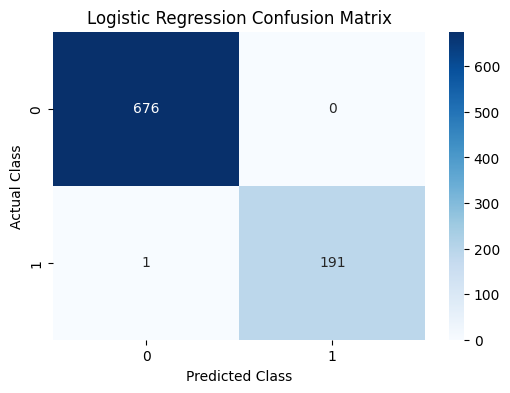

In [33]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' is good for smaller datasets and binary classification

# Use the training data (X_train, y_train) which is already defined
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Display the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d',
            cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### 8.2) Random Forest Classifier Model
**Model Performance:**

- Accuracy: 1.00

- Class 0 (Not HighValue): Precision: 1.00, Recall: 1.00, F1-score: 1.00

- Class 1 (HighValue): Precision: 0.99, Recall: 0.99, F1-score: 0.99



In [34]:
# Model training with hyperparameter tuning
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [5,10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid, cv=5, scoring='recall')
rf.fit(X_train, y_train)

print("Best params:", rf.best_params_)

# Note: It takes 16 minutes to train all the hyperparameter
# param_grid_expanded = {
#     'n_estimators': [50, 100, 200, 300], # Explore more values
#     'max_depth': [5, 10, 15, 20, None], # Explore more values, including no limit
#     'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
#     'max_features': ['sqrt', 'log2', None] # Number of features to consider when looking for the best split
# }

# rf_expanded_grid = GridSearchCV(RandomForestClassifier(random_state=42),
#                                  param_grid_expanded, cv=5, scoring='f1', n_jobs=-1) # n_jobs=-1 uses all available cores
# rf_expanded_grid.fit(X_train, y_train)

# print("Best params from expanded grid:", rf_expanded_grid.best_params_)
# print("Best F1 score from expanded grid:", rf_expanded_grid.best_score_)


Best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [35]:
# Predictions and metrics
y_pred_rf = rf.predict(X_test)
print(y_pred_rf)
print(classification_report(y_test, y_pred_rf))

[0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

**Random Forest Confusion Matrix:**
- Correctly predicted Not High-Value: 674 (True Negatives)

- Incorrectly predicted High-Value (was Not High-Value): 2 (False Positives)

- Incorrectly predicted Not High-Value (was High-Value): 1 (False Negatives - No high-value customers were missed)

- Correctly predicted High-Value: 191 (True Positives)



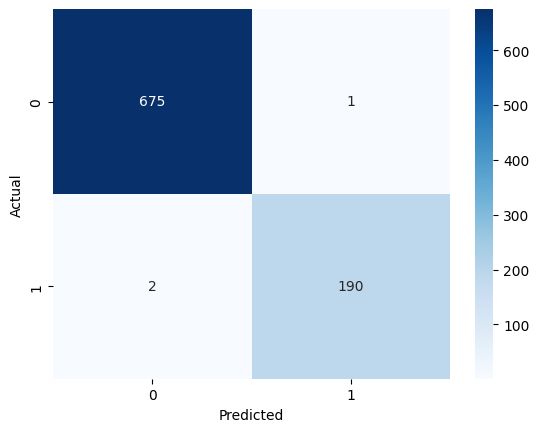

In [36]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d',
            cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

**Comparison:**

- False Positives: Logistic Regression has 0 false positives, while Random Forest has 2. This means Logistic Regression is better at not incorrectly labeling a non-high-value customer as high-value. This can be important to avoid wasted marketing efforts or negative customer experiences.

- False Negatives: Both models have 1 false negative. This means both models missed classifying one actual high-value customer as high-value. They are equally good at capturing the majority of high-value customers.

- True Positives & True Negatives: The counts are similar, reflecting overall good performance.
Recall (Ability to find all High-Value customers): Both models have the same recall for the high-value class based on these numbers.

- Precision (Accuracy of High-Value predictions): Logistic Regression has perfect precision (191/191 = 1.00) for the high-value class, while Random Forest has slightly lower precision (191/(191+2) ≈ 0.99).

**Conclusion:**

Based on the provided statistics, the Logistic Regression model is slightly better for deployment.  It correctly identifies high-value customers with perfect precision and misses the same number of high-value customers as Random Forest.

While Random Forest also performs well, its 2 false positives make Logistic Regression the preferred choice based on these specific confusion matrix counts.



---



## 9) Feature Importance:
Based on the "Feature Importances for HighValue Customer Prediction" chart, these are the insights:

The chart clearly shows the relative importance of each RFM feature in predicting whether a customer is "HighValue".

- Monetary value is the most important feature, having the longest bar.

- Frequency is the second most important feature.

- Recency is the least important feature compared to Monetary and Frequency.

This indicates that, for this model, how much a customer spends and how often they buy are stronger predictors of their high-value status than how recently they made a purchase.

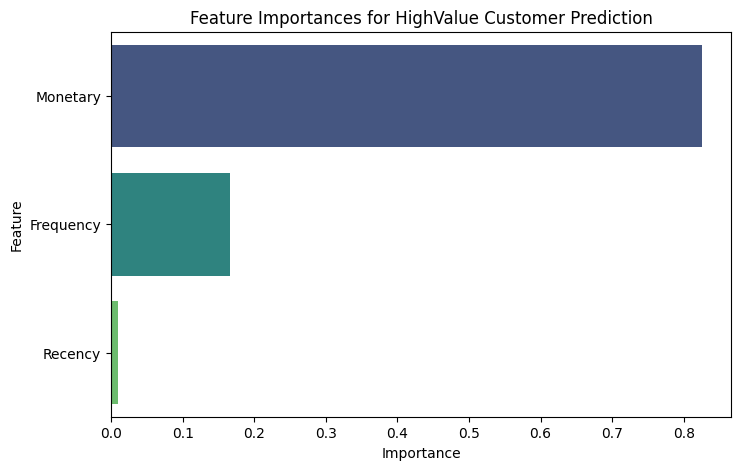

In [37]:
#feature importances from the trained model
feature_importances = rf.best_estimator_.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importances for HighValue Customer Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



---



## 10) Final Model Rebuilding

Coefficient Interpretation:

Recency (-1.077):
- Negative effect.
- More recent purchases → higher probability of being a high-value customer.

Frequency (4.994):
- Strong positive effect.
- More purchases → greater likelihood of high-value status.

Monetary (5.414):
- Strong positive effect.
- Higher spending → more likely to be a high-value customer.

Key Insights:

-> Lower Recency (recent activity) increases likelihood of being classified as high-value.

-> Higher Frequency and Monetary values heavily boost the probability.

-> Intercept (-6.876) represents the baseline log-odds when RFM values are zero.


In [38]:

# Rebuild the Logistic Regression model using the full scaled RFM data
log_reg_final = LogisticRegression(random_state=42, solver='liblinear')

# Train the model on the entire rfm_scaled dataset (X_full) and the 'HighValue' target variable (y_full)
# 'rfm_scaled' is the complete scaled dataset (which was 'X' before the train/test split)
X_full = rfm_scaled
y_full = rfm['HighValue']

log_reg_final.fit(X_full, y_full)

print("Final Logistic Regression model trained on the full dataset.")
print("Model Coefficients:")
print(pd.DataFrame(log_reg_final.coef_.T, index=X_full.columns, columns=['Coefficient']))
print("Model Intercept:", log_reg_final.intercept_)


Final Logistic Regression model trained on the full dataset.
Model Coefficients:
           Coefficient
Recency      -1.076709
Frequency     4.994309
Monetary      5.413729
Model Intercept: [-6.87647673]




---



## 11) Saving the Model and Segmented .csv file:
**11.1) Save the Final Model and Scaler in a .pkl file:**

- Saved the Final Model: A .pkl file with chosen final trained model Logistic Regression has been created. This model is now ready to be loaded and used for making predictions in your deployment application.

- Saved the Fitted Scaler: An another .pkl file saved the StandardScaler object that was fitted on the RFM data during the preprocessing stage. This is essential for correctly scaling any new customer data before feeding it to your saved model for prediction.

In [ ]:
# Define the directory to save the model and scaler
model_dir = 'path/data'
os.makedirs(model_dir, exist_ok=True)

# Define file paths for the model and scaler files
# Using a clear name for the Logistic Regression model
model_path = os.path.join(model_dir, 'logistic_regression_final_model.pkl')
scaler_path = os.path.join(model_dir, 'scaler.pkl')

# Save the final trained Logistic Regression model
if 'log_reg_final' in globals():
    joblib.dump(log_reg_final, model_path)
    print(f"Final Logistic Regression model saved successfully to: {model_path}")
else:
    print("Error: log_reg_final model not found. Please run the cell to train the final Logistic Regression model first.")
    print("The model was not saved.")


# Save the fitted scaler object (assuming 'scaler' object exists from cell u0XM0-8FLhTT)
if 'scaler' in globals():
    joblib.dump(scaler, scaler_path)
    print(f"Fitted scaler saved successfully to: {scaler_path}")
else:
     print("Error: scaler object not found. Please run the data scaling cell (u0XM0-8FLhTT) first.")
     print("The scaler was not saved.")

print(f"\nModel and scaler saved in the directory: {model_dir}")

Final Logistic Regression model saved successfully to: /content/drive/MyDrive/Capstone project/logistic_regression_final_model.pkl
Fitted scaler saved successfully to: /content/drive/MyDrive/Capstone project/scaler.pkl

Model and scaler saved in the directory: /content/drive/MyDrive/Capstone project


**11.2) Save the Segmentation in a .csv file:**

Created Segmentation CSV: A CSV file containing each customer's ID and their assigned K-Means segment label. This file (customer_segmentation_results.csv) can be used for further analysis or for identifying customers within each segment.

In [ ]:
# Ensure rfm DataFrame is available and contains the 'KMeansSegment' column

# Create a new DataFrame with CustomerID and KMeansSegment
customer_segments_df = rfm[['KMeansSegment']].reset_index()

# Define the directory and path for the segmentation CSV
segmentation_dir = 'path/data'
os.makedirs(segmentation_dir, exist_ok=True)
segmentation_csv_path = os.path.join(segmentation_dir, 'customer_segmentation_results.csv')

# Save the DataFrame to a CSV file
customer_segments_df.to_csv(segmentation_csv_path, index=False)

print(f"Customer segmentation results saved successfully to: {segmentation_csv_path}")

Customer segmentation results saved successfully to: /content/drive/MyDrive/Capstone project/customer_segmentation_results.csv


Created rfm.csv:
The code prepares and saves cleaned customer RFM metrics, K-Means segment labels, and HighValue classification into a structured rfm.csv file, making it ready for easy import and visualization in dashboarding tools.

In [ ]:
# creating a new csv file for dashboard purpose
# Reset the index to make CustomerID a column
rfm_dashboard_df = rfm.reset_index()


# Make sure 'HighValue' and 'KMeansSegment' column names match what's in your rfm DataFrame
desired_columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'KMeansSegment', 'HighValue']

# Handle potential missing columns gracefully
available_columns = [col for col in desired_columns if col in rfm_dashboard_df.columns]
rfm_dashboard_df = rfm_dashboard_df[available_columns]

# Define the directory and path for the rfm.csv file
csv_dir = 'path/data'
os.makedirs(csv_dir, exist_ok=True)
csv_path = os.path.join(csv_dir, 'rfm.csv')

# Save the DataFrame to a CSV file
rfm_dashboard_df.to_csv(csv_path, index=False)

print(f"rfm.csv saved successfully to: {csv_path}")
print("This file contains data ready for use in a dashboard.")

rfm.csv saved successfully to: /content/drive/MyDrive/Capstone project/rfm.csv
This file contains data ready for use in a dashboard.




---



## 12) Deployment of Final Model using Gradio app:
### Summary of the Activites Done in this gradio_app.py:

*   **Loaded a Machine Learning Model and Scaler:** Has started by loading a pre-trained machine learning model (specifically, a Logistic Regression model) and a data scaler (`scaler.pkl`). These are essential components for making predictions.

*   **Set up a Gradio Interface:** Also created a web-based interface using the Gradio library. This interface allows to input Recency, Frequency, and Monetary values and get a prediction from your loaded model in a user-friendly way.

*   **Troubleshooted Gradio Access:** The access of the Gradio app when running in Google Colab, the use of the public URL and suggesting `ngrok` as an alternative if direct access is difficult.

*   **Model Prediction Behavior:** Explored why certain RFM values might not result in a "High Value Customer" prediction, emphasizing that the model's predictions are based on the data it was trained on and its learned thresholds, not on manually defined rules in the app.

*   **Performed Programmatic Experiments:** A generated code has been created to programmatically test the loaded model with different sets of RFM values. This allowed to see the model's predictions and associated probabilities for various inputs directly within the notebook.

*   **Added Success Indicators to Code:** The code has been modified for the programmatic experiments to include print statements indicating whether the prediction step was successfully executed.